In [ ]:
%load_ext autoreload
%autoreload 2
%cd ~/shared/eramzi/VideoActionModel

import random
import os
import pickle
from typing import List, Optional

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from einops import rearrange

from vam.datalib import CropAndResizeTransform, EgoTrajectoryDataset, torch_image_to_plot
from vam.utils import expand_path
from vam.video_pretraining import load_pretrained_gpt

Image = Tensor | np.ndarray | List[Tensor] | List[np.ndarray]

device = "cuda"
dtype = torch.bfloat16

/home/eramzi/shared/eramzi/NextTokenPredictor


In [2]:
tokenizer_jit_path = "~/iveco/scratch_iveco/llamagen_jit_models/VQ_ds16_16384_llamagen_encoder.jit"
detokenizer_jit_path = "~/iveco/scratch_iveco/llamagen_jit_models/VQ_ds16_16384_llamagen_decoder.jit"
# VM-S
gpt_checkpoint_path = "~/iveco/scratch_iveco/VAM_JZGC4/checkpoints/Finetune/width_768_pretrained_139k_total_155k.pt"
name = "VM_S"
# VM-B
# gpt_checkpoint_path = "~/iveco/scratch_iveco/VAM_JZGC4/checkpoints/Finetune/width_1024_pretrained_139k_total_155k.pt"
# name = "VM_B"
# VM-L
# gpt_checkpoint_path = "~/iveco/scratch_iveco/VAM_JZGC4/checkpoints/Finetune/width_2048_pretrained_139k_total_155k.pt"
# name = "VM_L"

tokenizer = torch.jit.load(expand_path(tokenizer_jit_path)).to("cuda")
detokenizer = torch.jit.load(expand_path(detokenizer_jit_path)).to("cuda")
gpt = load_pretrained_gpt(expand_path(gpt_checkpoint_path), tempdir=os.environ.get("JOBSCRATCH", "/tmp"))

/home/eramzi/shared/eramzi/NextTokenPredictor/vam/video_pretraining/mup_gpt2.py:627: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_loc

number of non-embedding parameters: 182.45M


In [4]:
def get_nuscenes(context_length: int) -> EgoTrajectoryDataset:
    with open(expand_path("~/iveco/scratch_iveco/VAM_JZGC4/pickles/nuscenes_val_data_cleaned.pkl"), "rb") as f:
        pickle_data = pickle.load(f)

    transform = CropAndResizeTransform(resize_factor=3.125, trop_crop_size=0)

    return EgoTrajectoryDataset(
        pickle_data=pickle_data,
        images_rootdir=expand_path("/datasets_local/nuscenes"),
        sequence_length=context_length,
        images_transform=transform,
    )

context_length = 4
prediction_length = 4

dataset = get_nuscenes(context_length)

In [5]:
def plot_images(
    images: Image,
    save_path: Optional[str] = None,
    num_rows: Optional[int] = None,
    num_cols: Optional[int] = None,
) -> None:
    num_rows = len(images) if isinstance(images, list) else 1
    num_cols = max(len(img) for img in images) if isinstance(images, list) else len(images)

    fig = plt.figure(figsize=(20, 5))
    axes = fig.subplots(num_rows, num_cols)
    if num_rows == 1:
        axes = [axes]

    idx = 0
    for row in range(num_rows):
        if isinstance(images, list):
            idx = 0
        for col in range(num_cols):
            if idx >= (len(images[row]) if isinstance(images, list) else len(images)):
                break
            if isinstance(images, list):
                axes[row][col].imshow(images[row][idx])
            else:
                axes[row][col].imshow(images[idx])
            axes[row][col].axis("off")
            idx += 1
            # plot_idx += 1
            axes[row][col].set_xticks([])
            axes[row][col].set_yticks([])

    # Ensure tight layout
    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig

In [7]:
idx = random.randint(0, len(dataset) - 1)
print("Generating from idx:", idx)
sample = dataset[idx]

with torch.amp.autocast(device, dtype=dtype):
    tokens = tokenizer(sample["image"].to(device, non_blocking=True))
    tokens = rearrange(tokens, "(1 t) ... -> 1 t ...", t=context_length)

    generated_tokens = gpt.forward_inference(
        number_of_future_frames=prediction_length,
        burnin_visual_tokens=tokens,
        topk_sampler=1,
        temperature=1.0,
        use_kv_cache=True,
    )

generated_images = detokenizer(rearrange(generated_tokens, "1 t ... -> (1 t) ..."))
generated_images = torch_image_to_plot(generated_images, to_numpy=False)
generated_images = rearrange(generated_images, "(1 t) ... -> 1 t ...", t=prediction_length).cpu().numpy()

_images = torch_image_to_plot(sample["image"], to_numpy=False)
_images = rearrange(_images, "(1 t) ... -> 1 t ...", t=context_length).cpu().numpy()

1910


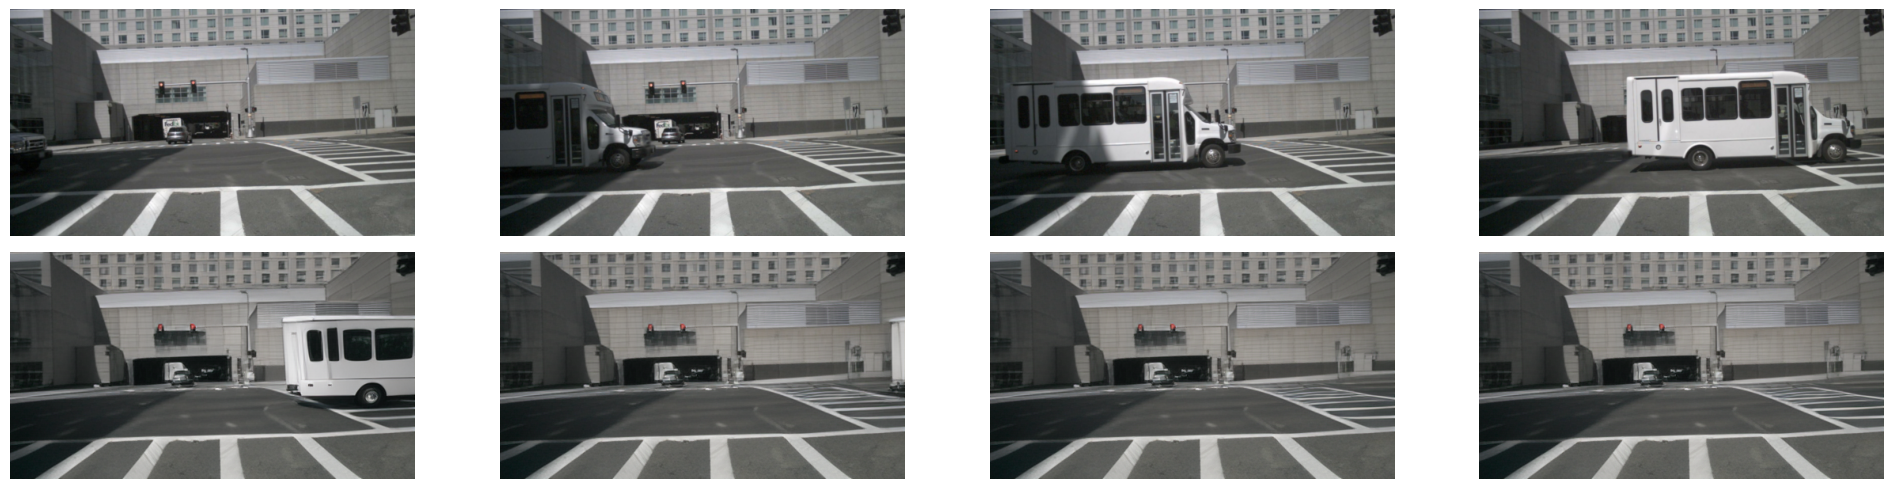

In [10]:
_ = plot_images([_images[0], generated_images[0]], save_path="figs/{}_{}.png".format(name, idx))